# Vector Mediator Constraints

In [1]:
from hazma.vector_mediator import KineticMixing
from hazma.parameters import electron_mass as me
import numpy as np
import matplotlib.pyplot as plt

mp = 938.28 # proton mass MeV

## LSND

In [2]:
model = KineticMixing(250.0, 1000.0, 1.0, 1e-3)

In [3]:
model.partial_widths()

{'pi pi': 5.38424450162404e-07,
 'pi0 g': 2.2120472127152514e-10,
 'x x': 25.8435419728965,
 'e e': 2.4323798404348874e-06,
 'mu mu': 2.4305332100254337e-06,
 'total': 25.843547374455206}

In [4]:
class VectorMediatorConstraintsLSND(KineticMixing):
    """
    Class for computing the LSND constriants on
    the kinetic mixing model.
    """
    lsh = 25.85 * 5.06773e12 # base-line in MeV^-1
    ldec = 8.3  * 5.06773e12 # detector length MeV^-1
    Nin = 9.2e22
    Nobs = 25.0
    N95 = 50.0
    Ep = 800.0 + mp # MeV
    
    def __init__(self, mx, mv, gvxx, eps):
        super(VectorMediatorConstraintsLSND,self).__init__(mx,mv,gvxx,eps)
    
    def _sigmapp(self,sp):
        """
        Inelastic scattering cross section for proton proton scattering.
        
        Parameters
        ----------
        sp: float
            Center of mass energy
        """
        Z = 35.45 # mb
        B = 0.308 # mb
        Y1 = 42.53 # mb
        Y2 = 33.34 # mb
        s0 = 5.38**2 # GeV^2
        s1 = 1.0**2 # GeV^2
        eta1 = 0.458
        eta2 = 0.545
        res = Z + B * np.log(sp / s0) + Y1 * (s1 / sp)**eta1 - Y2 * (s1/sp)**eta2
        # Convert to MeV^-2
        return res * 2.56819 * 1e6
    
    def _wba(self,pT2, Ev):
        z = np.sqrt(Ev**2 - pT2) / self.Ep
        h = pT2 + (1.0 - z) * self.mv**2 + z**2 * mp**2
        
        term1 = (1.0 + (1.0 - z)**2) / z 
        term2 = -2.0 * z * (1.0 - z) * ((2.0 * mp**2 + self.mv**2) / h - z**2 * 2.0 * mp**4 / h**2)
        term3 = 2.0 * z * (1.0 - z) * (1.0 + (1.0 - z)**2) * mp**2 * self.mv**2 / h**2
        term4 = 2.0 * z * (1.0 - z)**2 * self.mv**4 / h**2
        
        return (term1 + term2 + term3 + term4) / h * self.gvxx**2 / (8.0 * np.pi**2)

    def dnde(self, Ev):
        width = self.partial_widths()['total']
        
        pT2max = Ev**2
        pT2s = np.linspace(0.0, pT2max, num=100)
        wint = np.trapz(self._wba(pT2s, Ev), pT2s, axis=0)

        s = 2.0 * mp * self.Ep
        sp = 2.0 * mp * (self.Ep - Ev)
        beta = np.sqrt(1.0 - self.mv**2 / Ev**2)
        lv = beta * Ev / self.mv / width
        return (
            self._sigmapp(sp) / self._sigmapp(s) / self.Ep * wint * 
            np.exp(-self.lsh/lv) * (1.0 - np.exp(-self.ldec/lv)) * 
            self.partial_widths()['e e'] / width
        )
    
    def num_events(self):
        Evs = np.linspace(self.mv , self.Ep - mp, num=100)
        return self.Nin * np.trapz(self.dnde(Evs), Evs)
        

In [5]:
lsnd_const = VectorMediatorConstraintsLSND(1000.0, 30.0, 1.0, 1e-8)

In [6]:
mvs = np.logspace(np.log10(2.0 * me), 3.0, 50)
epss = np.logspace(-9, -3, 50)

In [7]:
lsnd_consts = np.asarray([[VectorMediatorConstraintsLSND(250.0, mv, 1.0, eps).num_events()
                for eps in epss]for mv in mvs])

<ipython-input-4-43bddc04bbbc>:41: RuntimeWarning: divide by zero encountered in true_divide
  term1 = (1.0 + (1.0 - z)**2) / z
<ipython-input-4-43bddc04bbbc>:58: RuntimeWarning: divide by zero encountered in true_divide
  lv = beta * Ev / self.mv / width
<ipython-input-4-43bddc04bbbc>:58: RuntimeWarning: invalid value encountered in true_divide
  lv = beta * Ev / self.mv / width
<ipython-input-4-43bddc04bbbc>:60: RuntimeWarning: invalid value encountered in multiply
  self._sigmapp(sp) / self._sigmapp(s) / self.Ep * wint *
<ipython-input-4-43bddc04bbbc>:61: RuntimeWarning: divide by zero encountered in true_divide
  np.exp(-self.lsh/lv) * (1.0 - np.exp(-self.ldec/lv)) *
<ipython-input-4-43bddc04bbbc>:57: RuntimeWarning: invalid value encountered in sqrt
  beta = np.sqrt(1.0 - self.mv**2 / Ev**2)


In [8]:
lsnd_consts

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

/home/logan/.local/lib/python3.8/site-packages/matplotlib/colors.py:1062: RuntimeWarning: invalid value encountered in true_divide
  resdat /= (vmax - vmin)


Text(0.5, 0, '$m_{V} \\ (\\mathrm{MeV})$')

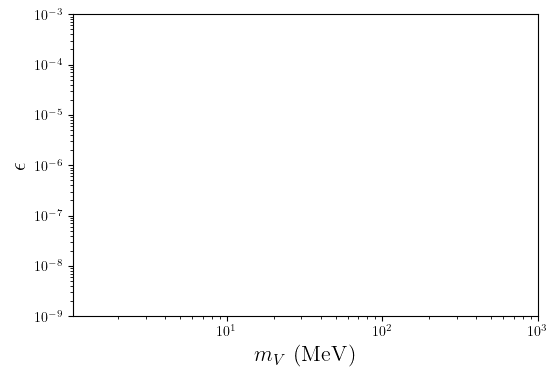

In [9]:
plt.figure(dpi=100)
plt.contourf(mvs,epss,np.nan_to_num(lsnd_consts).T,levels=[lsnd_const.N95,np.inf])
plt.yscale('log')
plt.xscale('log')
plt.ylabel(r'$\epsilon$', fontsize=16)
plt.xlabel(r'$m_{V} \ (\mathrm{MeV})$', fontsize=16)

In [2]:
class VectorMediatorConstraints(KineticMixing):
    """
    Master class of all the constraints on the 
    vector mediator model.
    """
    def __init__(self, mx, mv, gvxx, eps):
        super(VectorMediatorConstraints,self).__init__(mx,mv,gvxx,eps)